## Monte Carlo 

### 1) Imports

In [13]:
#imports
import os
import math
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits as tk
from numba import jit
from IPython import display

In [14]:
#magic commands
%load_ext autoreload
%autoreload 2

#inline plotting
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#fix numpy's random number generator seed
np.random.seed(17896)

### 2) Wrap to Periodic Boundary Conditions

In [16]:
#apply periodic boundary conditions of LxLxL cubic box to particle
#whose (x,y,z) coordinates are held in 3-element vector r
def wrap(r, L): 
    
    #r[0]=x, r[1]=y, r[2]=z
    
    #if x < l, x = x+L
    if (r[0] < L): 
        r[0] = r[0] + L
    #if x > L, x = x-L
    if (r[0] > L): 
        r[0] = r[0] - L
    #if x = L, map back to 0
    if (r[0] == L):
        r[0] = 0
        
        
    #if y < l, y = y+L
    if (r[1] < L): 
        r[1] = r[1] + L
    #if y > L, y = y-L
    if (r[1] > L): 
        r[1] = r[1] - L
    #if y = L, map back to 0
    if (r[1] == L):
        r[1] = 0
        
    #if z < l, z = z+L
    if (r[2] < L): 
        r[2] = r[2] + L
    #if z > L, z = z-L
    if (r[2] > L): 
        r[2] = r[2] - L
    #if z = L, map back to 0
    if (r[2] == L):
        r[2] = 0
    
    return r

### 3) Minimum Image Distance

In [17]:
#compute minimum image distance between 2 atoms whose (x,y,z) 
#coordinates are held in 3-element vectors r1 and r2
def dist(r1, r2, L): 
    
    #first wrap both atoms to make sure inside box
    r1 = wrap(r1, L)
    r2 = wrap(r2, L)
    
    #define dx, dy, and dz as the absolute values of the differences 
    #in each coordinate direction per vector
    dx = abs(r1[0] - r2[0])
    dy = abs(r1[1] - r2[1])
    dz = abs(r1[2] - r2[2])
    
    #if any of the distances (in x,y,z direction) are greater than half the
    #length of the box, the minimum image distance should be re defined as 
    # L - the original separation
    if (dx > L/2): 
        dx = L - dx
    if (dy > L/2): 
        dy = L - dy
    if (dz > L/2): 
        dz = L - dz
    
    #distance equation (magnitude)
    d = math.sqrt((dx)**2+(dy)**2+(dz)**2)
    
    return d  

### 4) Pairwise Energy

In [18]:
#compute energy between 2 particles i and j separated by a distance
#s according to the Lennard-Jones potential
def E_ij(s, sigma, epsilon):
    
    #lennard jones formula for energy
    q6 = (sigma/s)**6
    q12 = q6**2
    
    return 4*epsilon*(q12-q6)

### 5) Pairwise Force

In [19]:
#compute the force on particle i exerterd by particle j under Lennard-Jones
#potential, wheere r = r_ij = r_j - r_i
def f_ij(r, sigma, epsilon):
    
    s = math.sqrt(r[0]**2+r[1]**2+r[2]**2)
    
    q6 = (sigma/s)**6
    q12 = q6**2
    
    return -(48*epsilon/s**2)*(q12 - 0.5*q6)*r

### 6) Initialization - random

In [20]:
#randomly position the N Ar atoms within the cubic box of side length L
#avoiding collisions between particles at distances closer than sigma
def init_rand(N, L, sigma):
    
    #initialize xyz as N x 3 matrix
    xyz = np.zeros((N, 3))
    
    for i in range(0,N): 
        
        #create a test array for positions, only accept the position at i if not within sigma of any other positions
        pos = np.zeros((N, 3))
        pos[i] = np.random.random(3)*L
        
        #loop through all positions, only accept the position at i if not within sigma of any other atoms
        count = 0
        while (count < i):
    
            #if within sigma, create new random position
            if (dist(xyz[count], pos[i], L) < sigma):
                
                pos[i] = np.random.random(3)*L
                count = 0 
                
            count+=1
        
        #accept position, add it to xyz
        xyz[i] = pos[i]
       
    return xyz

### 7) Initialization - crystal

In [21]:
#position the N Ar atoms within the cubic box of side length L on a 
#simple cubic crystal lattice
def init_xtal(N, L):
    
    #initialize empty position array that is 3 dimensions (xyz) x the number of atoms
    pos = np.zeros((N, 3))
    
    #take the cubic root of the total number of atoms to find the number in a single dimension
    nPerSide = int(np.ceil(pow(N,(1.0/3.0)))) 
    
    
    #initialize every position of atoms in a 3D box, dependent on the desntiy (length of the side, number of atoms per that length)
    counter = 0 #start at position 0
    for i in range(0,nPerSide): #x
        for j in range(0,nPerSide): #y
            for k in range(0,nPerSide): #z
                if (counter < N):
                    #initialize positions at #(x,y,z)*L/dimension
                    pos[counter, 0] = i*L/nPerSide
                    pos[counter, 1] = j*L/nPerSide
                    pos[counter, 2] = k*L/nPerSide
                    counter += 1 
                    
    return pos

### 8) Total Energy

In [22]:
#compute the total potential energy of a hypothetical particle at location
#r = r(vector) with rest of system of particle held in xyz with exception of
#particle i 
#(aka, return energy of system if particle i moved to new location w/o 
#modifying xyz)
def E_i(r, i, xyz, L, sigma, epsilon):
    
    N = xyz.shape[0]
    
    #initialize E to 0
    E_i = 0
    
    #sum over all pairwise interactions between particle i and rest of atoms (skipping i = j because that refers to same atom)
    for j in range(N):
        if j!=i:
            rj = xyz[j,:]
            d = dist(r,rj,L)
            #then add pairwise energy between i and each particle in system to total
            E_i += E_ij(d,sigma,epsilon)
    
    return E_i

In [23]:
#compute the total potential energy of the system
def E_system(xyz, L, sigma, epsilon):
    
    N = xyz.shape[0]
    
    #initialize system E ot 0
    Esys = 0
    
    #loop through pairwise interactions between ALL atoms
    for ii in range(N):
        r1 = xyz[ii,:]
        for jj in range(ii):
            r2 = xyz[jj,:]
            d = dist(r1,r2,L)
            #then add pairwise energy between i and each particle in system to total
            Esys += E_ij(d,sigma,epsilon)
    
    return Esys

### 9) Visualization

In [24]:
#grpahing function to plot system configuration held in xyz
def plot_config(xyz, L):
    
    #plot the 3D representation of xyz
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    #set axes [0, L]
    ax.axes.set_xlim3d(left=0, right=L)  
    ax.axes.set_ylim3d(bottom=0, top=L) 
    ax.axes.set_zlim3d(bottom=0, top=L) 
    #labels
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_zlabel('z (nm)')
    ax.scatter(x, y, z, c=z, alpha=1)

    plt.show()

### 10) Coordinate write

In [25]:
#write current (x,y,z) coordinate triplets of all N atoms in system
#to file in xyz-format
def xyzWrite(xyz, outfile, writestyle):
    
    #either open the file as write or append 
    if (writestyle == 'w'): 
        outFile = open(outfile, 'w')
    if (writestyle == 'a'):
        outFile = open(outfile, 'a')
    
    #write to file in xyz format
    N = xyz.shape[0]
    outFile.write("%d\n" % N)
    outFile.write("\n")
  
    for i in range(0, xyz.shape[0]):
        #nm->angstroms
        outFile.write("Ar %6.2f %6.2f %6.2f\n" % (xyz[i,0]*10, xyz[i,1]*10, xyz[i,2]*10))
     
    outFile.close()               

### 11) Deployment

Illustrate successful deployment:

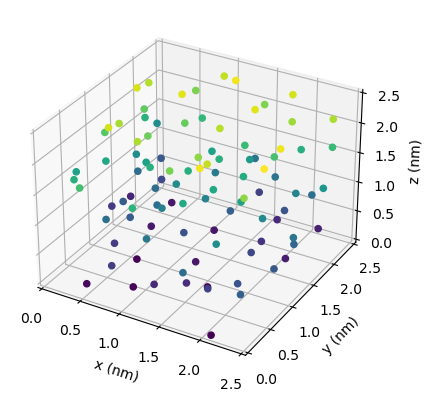

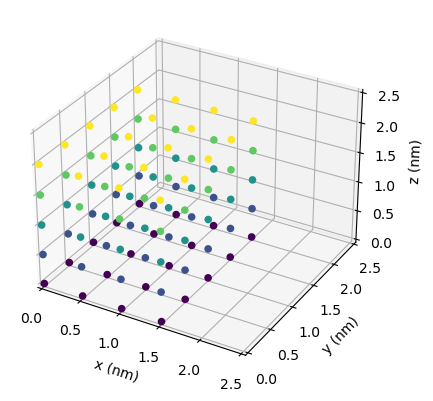

i = 0, j = 1
dij = 0.500000 nm
Eij = -0.588012 zJ
rij (nm):
[0.  0.  0.5]
fij (zJ/nm):
[0.         0.         6.28197961]
[0. 0. 0.]
Ei = -3.930762 zJ
E = -221.494854 zJ


In [26]:
N = 100
L = 2.5 # nm
sigma = 0.34 # nm
epsilon = 1.65 #zJ

xyz = init_rand(N, L, sigma)
plot_config(xyz, L)

xyz = init_xtal(N, L)
plot_config(xyz, L)

i = 0
j = 1
print('i = %d, j = %d' % (i,j))

dij = dist(xyz[i,:],xyz[j,:], L)
print('dij = %f nm' % dij)

Eij = E_ij(dij,sigma,epsilon)
print('Eij = %f zJ' % Eij)

rij = xyz[j,:] - xyz[i,:]
print('rij (nm):')
print(rij)

fij = f_ij(rij,sigma,epsilon)
print('fij (zJ/nm):')
print(fij)

print(xyz[i,:])
Ei = E_i(xyz[i,:],i,xyz,L,sigma,epsilon)
print('Ei = %f zJ' % Ei)

E = E_system(xyz,L,sigma,epsilon)
print('E = %f zJ' % E)

outfile = './ArgonFluid.xyz'
xyzWrite(xyz, outfile, 'w')

### 12) User Input 

In [18]:
T = float(input("Temperature: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
nSweeps = int(input("Number of MC Sweeps: "))
dispSize = float(input("Characteristic Size of Atomic Displacement Trial Moves: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
kB = float(input("Boltzmann's constant: "))

Temperature: 298
Cubic Box Side Length: 2.5
Number of Atoms: 200
Number of MC Sweeps: 750
Characteristic Size of Atomic Displacement Trial Moves: 0.1
Frequency of Prints to Screen: 10
Freqeuncy of Writes to File: 10
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Boltzmann's constant: 0.038064852


### 13) Main Metropolis Monte Carlo Loop

In [27]:
def MCMC(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB):
    
    #crystal configuration
    xyz = init_xtal(N, L)
    
    #for writing to outfile
    outfile = './Argon_MonteCarlo.xyz'
    xyzWrite(xyz, outfile, 'a')
    
    #initializations
    E = 0
    num_accept = 0
    num_trials = 0
    
    #for plotting
    E_list = np.zeros(nSweeps)
    Sweeps_list = np.zeros(nSweeps)
    
    #inital system energy
    E = E_system(xyz,L,sigma,epsilon)
    
    for i in range(0, nSweeps):
        for j in range(0, N):
            
            #choose random atom
            atom = np.random.randint(0, N)
      
            #store old coordinates
            xyz_atom_old = xyz[atom,:]
            
            #store old configuration energy
            E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)
            
            #random displacement change according to dispSize
            xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)
            
            #wrap positions
            xyz_atom_new_wrap = wrap(xyz_atom_new,L)
            
            #store new configuration energy
            E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)
            
            #calculte energy change
            deltaE = E_atom_new - E_atom_old
         
            #automatically accept lower energy config
            if deltaE < 0:
                xyz[atom,:] = xyz_atom_new_wrap
                E += deltaE
                num_accept += 1
                
            #apply displacement move acceptance criteria
            else:
                if T>0:
                    if np.random.random() < np.exp(-deltaE/(kB*T)):
                        xyz[atom,:] = xyz_atom_new_wrap
                        E += deltaE
                        num_accept += 1
             
            num_trials += 1
        
        #add values to be able to plot
        E_list[i] = E
        Sweeps_list[i] = i+1
        
        #print every printModulus Sweeps
        if(i % printModulus == 0):
            print("System Energy: %.3f" % E)
            if (num_trials > 0):
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
            print("")
        
        #write every writeModulus Sweeps
        if(i % writeModulus == 0):
            xyzWrite(xyz, outfile, 'a')
            
    plt.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
    plt.ylabel('Energy (zJ)')
    plt.xlabel('Sweep Number')
    plt.legend()
    plt.show()
                  

System Energy: -26.563
Acceptance Ratio: 1.000

System Energy: -58.688
Acceptance Ratio: 0.720

System Energy: -71.854
Acceptance Ratio: 0.649

System Energy: -85.543
Acceptance Ratio: 0.610

System Energy: -108.519
Acceptance Ratio: 0.557

System Energy: -124.247
Acceptance Ratio: 0.515

System Energy: -124.386
Acceptance Ratio: 0.484

System Energy: -133.107
Acceptance Ratio: 0.454

System Energy: -120.352
Acceptance Ratio: 0.442

System Energy: -121.751
Acceptance Ratio: 0.428

System Energy: -130.380
Acceptance Ratio: 0.411

System Energy: -139.303
Acceptance Ratio: 0.396

System Energy: -141.298
Acceptance Ratio: 0.384

System Energy: -150.904
Acceptance Ratio: 0.372

System Energy: -157.724
Acceptance Ratio: 0.363

System Energy: -172.497
Acceptance Ratio: 0.351

System Energy: -162.803
Acceptance Ratio: 0.342

System Energy: -153.119
Acceptance Ratio: 0.337

System Energy: -161.448
Acceptance Ratio: 0.331

System Energy: -166.965
Acceptance Ratio: 0.326

System Energy: -172.733


System Energy: -225.946
Acceptance Ratio: 0.160

System Energy: -226.394
Acceptance Ratio: 0.160

System Energy: -228.614
Acceptance Ratio: 0.159

System Energy: -222.647
Acceptance Ratio: 0.159

System Energy: -222.227
Acceptance Ratio: 0.159

System Energy: -230.619
Acceptance Ratio: 0.159

System Energy: -232.933
Acceptance Ratio: 0.159

System Energy: -233.852
Acceptance Ratio: 0.158

System Energy: -237.264
Acceptance Ratio: 0.158

System Energy: -237.091
Acceptance Ratio: 0.158

System Energy: -237.142
Acceptance Ratio: 0.157

System Energy: -235.143
Acceptance Ratio: 0.157

System Energy: -237.817
Acceptance Ratio: 0.157

System Energy: -236.658
Acceptance Ratio: 0.157

System Energy: -245.680
Acceptance Ratio: 0.156

System Energy: -240.212
Acceptance Ratio: 0.156

System Energy: -239.080
Acceptance Ratio: 0.156

System Energy: -242.089
Acceptance Ratio: 0.156

System Energy: -239.716
Acceptance Ratio: 0.155

System Energy: -227.614
Acceptance Ratio: 0.155

System Energy: -222.

System Energy: -223.184
Acceptance Ratio: 0.139

System Energy: -237.448
Acceptance Ratio: 0.139

System Energy: -244.787
Acceptance Ratio: 0.139

System Energy: -232.911
Acceptance Ratio: 0.139

System Energy: -233.300
Acceptance Ratio: 0.139

System Energy: -238.769
Acceptance Ratio: 0.139

System Energy: -240.153
Acceptance Ratio: 0.139

System Energy: -244.451
Acceptance Ratio: 0.138

System Energy: -239.218
Acceptance Ratio: 0.138

System Energy: -241.899
Acceptance Ratio: 0.138

System Energy: -244.594
Acceptance Ratio: 0.138

System Energy: -242.259
Acceptance Ratio: 0.138

System Energy: -240.724
Acceptance Ratio: 0.138

System Energy: -229.874
Acceptance Ratio: 0.138

System Energy: -227.764
Acceptance Ratio: 0.138

System Energy: -240.023
Acceptance Ratio: 0.137

System Energy: -241.375
Acceptance Ratio: 0.137

System Energy: -240.381
Acceptance Ratio: 0.137

System Energy: -238.317
Acceptance Ratio: 0.137

System Energy: -228.970
Acceptance Ratio: 0.137

System Energy: -238.

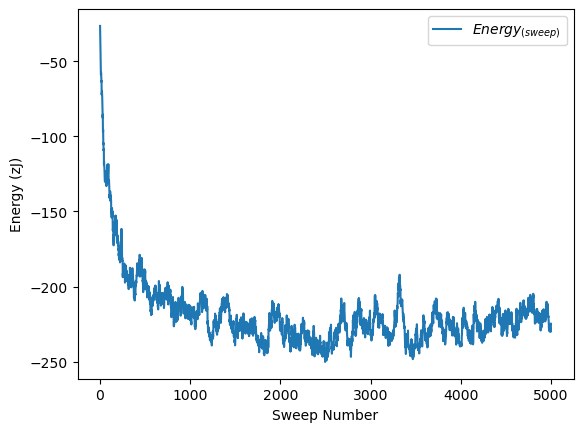

In [28]:
MCMC(50, 2.5, 40, 5000, 0.1, 10, 10, 0.34, 1.65, 1.38064852E-2)

### 14) Equation of State

#### Virial Equation

In [29]:
# pairwise distance vector
def dist_v(r1,r2,L):
    
    halfL = L/2.
    
    r12 = r2-r1
    
    for ii in range(3):
        if r12[ii] > halfL:
            r12[ii] -= L
        elif r12[ii] < -halfL:
            r12[ii] += L

    return r12

In [34]:
#compute the pressure in the simulation box using virial equation
def pressure(N, L, T, xyz, sigma, epsilon):
    
    kB = 1.38064852E-2
    P_kinetic = (N/(L*1E-9)**3)*kB*1E-21*T # Pa
    
    P_virial = 0
    for i in range(N):
        ri = xyz[i,:]
        for j in range(i):
            rj = xyz[j,:]
            rij = dist_v(ri,rj,L)
            fij = f_ij(rij,sigma,epsilon)
            P_virial += np.dot(rij,fij)
    P_virial *= 1E-21/(3*(L*1E-9)**3) # Pa
    
    P_kinetic /= 1E5 # bar
    
    P_virial /= 1E5 # bar
    
    return P_kinetic-P_virial

#### Pressure Calculation

In [31]:
def MCMC_plot(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB):
    
    xyz = init_rand(N, L, sigma)
    outfile = './ArgonNVT_Pressure.xyz'
    xyzWrite(xyz, outfile, 'a')
    
    #initializations
    E = 0
    
    #for plotting
    E_list = np.zeros(nSweeps)
    P_list = np.zeros(nSweeps)
    Sweeps_list = np.zeros(nSweeps)
    
    #counters
    num_accept = 0
    num_trials = 0
    
    #inital system energy
    E = E_system(xyz,L,sigma,epsilon)
    
    #MCMC Loop
    for i in range(0, nSweeps):
        for j in range(0, N):
            
            #choose random atom
            atom = np.random.randint(0, N)
      
            #store old coordinates
            xyz_atom_old = xyz[atom,:]
            
            #store old configuration energy
            E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)
            
            #random displacement change according to dispSize
            xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)
            
            #wrap positions
            xyz_atom_new_wrap = wrap(xyz_atom_new,L)
            
            #store new configuration energy
            E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)
            
            #calculte energy change
            deltaE = E_atom_new - E_atom_old
         
            #automatically accept lower energy config
            if deltaE < 0:
                xyz[atom,:] = xyz_atom_new_wrap
                E += deltaE
                num_accept += 1
                
            #apply displacement move acceptance criteria
            else:
                if T>0:
                    if np.random.random() < np.exp(-deltaE/(kB*T)):
                        xyz[atom,:] = xyz_atom_new_wrap
                        E += deltaE
                        num_accept += 1
             
            num_trials += 1
         
        #add values to be able to plot
        E_list[i] = E
        P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
        Sweeps_list[i] = i+1

        #print every printModulus Sweeps
        if(i % printModulus == 0):
            print("System Energy: %.3f" % E)
            print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
            print("")
          
        #write every writeModulus Sweeps
        if(i % writeModulus == 0):
            xyzWrite(xyz, outfile, 'a')
    
    #plots
    fig, (ax1, ax2) = plt.subplots(2,sharex=True)
    
    ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
    ax1.set_ylabel('Energy (zJ)')
    ax1.legend()
    
    ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
    ax2.set_ylabel('Pressure (bar)')
    ax2.legend()
    
    plt.xlabel('Sweep Number')
    plt.show()               

N = 200, T = 298 K, L = 2.5nm, nSweeps = 750, $\sigma$ = 0.34nm, $\epsilon$ = 1.65e-21 J

Choose dispSize such that acceptance probability ~ 50%

In [56]:
T = float(input("Temperature: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
nSweeps = int(input("Number of MC Sweeps: "))
dispSize = float(input("Characteristic Size of Atomic Displacement Trial Moves: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
kB = float(input("Boltzmann's constant: "))

Temperature: 298
Cubic Box Side Length: 2.5
Number of Atoms: 200
Number of MC Sweeps: 750
Characteristic Size of Atomic Displacement Trial Moves: 0.1
Frequency of Prints to Screen: 10
Freqeuncy of Writes to File: 10
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Boltzmann's constant: 0.0138064852


System Energy: -977.805
Acceptance Ratio: 0.705

System Energy: -1044.565
Acceptance Ratio: 0.656

System Energy: -975.702
Acceptance Ratio: 0.647

System Energy: -961.371
Acceptance Ratio: 0.637

System Energy: -943.059
Acceptance Ratio: 0.633

System Energy: -971.609
Acceptance Ratio: 0.631

System Energy: -983.367
Acceptance Ratio: 0.625

System Energy: -981.516
Acceptance Ratio: 0.626

System Energy: -942.790
Acceptance Ratio: 0.624

System Energy: -937.839
Acceptance Ratio: 0.622

System Energy: -961.286
Acceptance Ratio: 0.621

System Energy: -906.437
Acceptance Ratio: 0.618

System Energy: -953.992
Acceptance Ratio: 0.620

System Energy: -977.420
Acceptance Ratio: 0.622

System Energy: -945.193
Acceptance Ratio: 0.621

System Energy: -979.184
Acceptance Ratio: 0.621

System Energy: -997.341
Acceptance Ratio: 0.620

System Energy: -970.318
Acceptance Ratio: 0.619

System Energy: -1004.485
Acceptance Ratio: 0.618

System Energy: -1028.153
Acceptance Ratio: 0.618

System Energy: -1

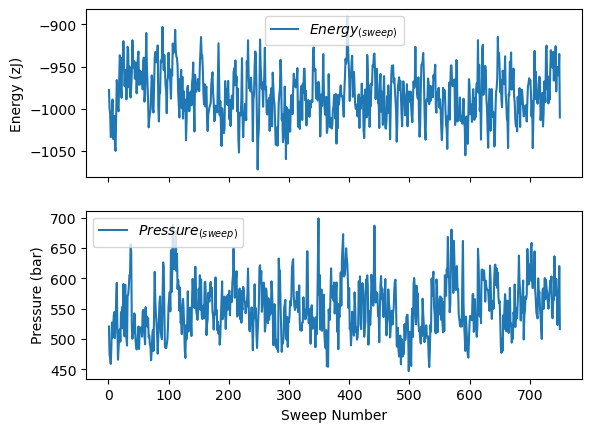

In [ ]:
MCMC_plot(298, 2.5, 200, 750, 0.06, 10, 10, 0.34, 1.65, 0.0138064852)

### 15) NPT Ensemble

Perform one volume-change trial per N particle displacement trial moves such that one MC Sweep comprises N particle displacement trials and one volume-change trial

In [32]:
#Metropolis Monte-Carlo Loop for NVT/NPT Ensemble
def MCMC_2(T, L, N, nSweeps, dispSize, printModulus, writeModulus, sigma, epsilon, kB, P_targ, flag):
    
    #NPT
    if(flag): 
        
        #random configuration
        xyz = init_rand(N, L, sigma)
        outfile = './ArgonNPT_Pressure.xyz'
        xyzWrite(xyz, outfile, 'a')
   
        #for plotting
        E_list = np.zeros(nSweeps)
        P_list = np.zeros(nSweeps)
        L_list = np.zeros(nSweeps)
        Sweeps_list = np.zeros(nSweeps)
        
        #counts
        num_accept = 0
        num_trials = 0
        
        #volume dispSize
        V_dispSize = 2

        #inital energy of the system
        E = E_system(xyz,L,sigma,epsilon)

        #MCMC Loop
        for i in range(0, nSweeps):
            
            #perform regular displacement trial N times
            for j in range(0, N):

                #choose random atom
                atom = np.random.randint(0, N)

                #store old coordinates
                xyz_atom_old = np.copy(xyz[atom,:])

                #store old configuration energy
                E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)

                #random displacement change according to dispSize
                xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)

                #wrap positions
                xyz_atom_new_wrap = wrap(xyz_atom_new,L)

                #store new configuration energy
                E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)

                #calculte energy change
                deltaE = E_atom_new - E_atom_old

                #automatically accept lower energy config
                if deltaE < 0:
                    xyz[atom,:] = np.copy(xyz_atom_new_wrap)
                    E += deltaE
                    num_accept += 1

                #apply displacement move acceptance criteria
                else:
                    if T>0:
                        if np.random.random() < np.exp(-deltaE/(kB*T)):
                            xyz[atom,:] = np.copy(xyz_atom_new_wrap)
                            num_accept += 1

                num_trials += 1
                    
            #now perform volume trial move
            
            #old volume
            V_old = L**3
            
            #calculate old energy
            E_old = E_system(xyz, L, sigma, epsilon)
            
            #new coordinates to edit
            xyz_new = np.copy(xyz)

            #random volume displacement
            dV = np.random.uniform(-V_dispSize,V_dispSize)

            #new volume 
            V_new = V_old + dV
            
            #new side length
            L_new = V_new**(1.0/3.0)

            #scale L_new/L_old
            scale = L_new/L
            
            #scale the particles to new positions
            xyz_new *= scale
            
            #calculate new energy
            E_new = E_system(xyz_new, L_new, sigma, epsilon)

            #calculate change in energy
            deltaE = E_new - E_old 

            if T>0:
                #acceptance condition for volume trial move
                log_chi =  -((deltaE + (P_targ / 10 * dV)) / (kB*T)) + (N * (np.log(V_new/V_old))) 
                if log_chi >= math.log(np.random.uniform(0,1)):
                    #update coordinates and side length
                    xyz = np.copy(xyz_new)
                    L = L_new
                    num_accept += 1       
            
            num_trials += 1
                
            #store values for plotting
            E_list[i] = E_system(xyz, L, sigma, epsilon)
            P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
            L_list[i] = L
            Sweeps_list[i] = i+1

            #print every printModulus sweeps
            if(i % printModulus == 0):
                print("System Energy: %.3f" % E)
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
                print("Pressure: %.2f" % P_list[i])
                print("")

            #write every writeModulus sweeps
            if(i % writeModulus == 0):
                xyzWrite(xyz, outfile, 'a')
            
        #plots
        fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True)
    
        ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
        ax1.set_ylabel('Energy (zJ)')
        ax1.legend()

        ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
        ax2.set_ylabel('Pressure (bar)')
        ax2.legend()

        ax3.plot(Sweeps_list, L_list, label='$Length_{(sweep)}$')
        ax3.set_ylabel('Side Length (nm)')
        ax3.legend()

        plt.xlabel('Sweep Number')
        plt.show()

    
    #NVT
    else:
        
        #random configuration
        xyz = init_rand(N, L, sigma)
        
        outfile = './ArgonNVT_Pressure.xyz'
        xyzWrite(xyz, outfile, 'a')

        #initializations
        E = 0

        #for plotting
        E_list = np.zeros(nSweeps)
        P_list = np.zeros(nSweeps)
        Sweeps_list = np.zeros(nSweeps)

        #counters
        num_accept = 0
        num_trials = 0

        #inital system energy
        E = E_system(xyz,L,sigma,epsilon)

        #MCMC Loop
        for i in range(0, nSweeps):
            for j in range(0, N):

                #choose random atom
                atom = np.random.randint(0, N)

                #store old coordinates
                xyz_atom_old = xyz[atom,:]

                #store old configuration energy
                E_atom_old = E_i(xyz_atom_old,atom,xyz,L,sigma,epsilon)

                #random displacement change according to dispSize
                xyz_atom_new = xyz_atom_old + dispSize*np.random.uniform(-1,1,3)

                #wrap positions
                xyz_atom_new_wrap = wrap(xyz_atom_new,L)

                #store new configuration energy
                E_atom_new = E_i(xyz_atom_new_wrap,atom,xyz,L,sigma,epsilon)

                #calculte energy change
                deltaE = E_atom_new - E_atom_old

                #automatically accept lower energy config
                if deltaE < 0:
                    xyz[atom,:] = xyz_atom_new_wrap
                    E += deltaE
                    num_accept += 1

                #apply displacement move acceptance criteria
                else:
                    if T>0:
                        if np.random.random() < np.exp(-deltaE/(kB*T)):
                            xyz[atom,:] = xyz_atom_new_wrap
                            E += deltaE
                            num_accept += 1

                num_trials += 1

            #add values to be able to plot
            E_list[i] = E
            P_list[i] = pressure(N, L, T, xyz, sigma, epsilon)
            Sweeps_list[i] = i+1

            #print every printModulus Sweeps
            if(i % printModulus == 0):
                print("System Energy: %.3f" % E)
                print("Acceptance Ratio: %.3f" % (num_accept/(num_trials)))
                print("")

            #write every writeModulus Sweeps
            if(i % writeModulus == 0):
                xyzWrite(xyz, outfile, 'a')

        #plots
        fig, (ax1, ax2) = plt.subplots(2,sharex=True)

        ax1.plot(Sweeps_list, E_list, label='$Energy_{(sweep)}$')
        ax1.set_ylabel('Energy (zJ)')
        ax1.legend()

        ax2.plot(Sweeps_list, P_list, label='$Pressure_{(sweep)}$')
        ax2.set_ylabel('Pressure (bar)')
        ax2.legend()

        plt.xlabel('Sweep Number')
        plt.show()

In [ ]:
T = float(input("Temperature: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
nSweeps = int(input("Number of MC Sweeps: "))
dispSize = float(input("Characteristic Size of Atomic Displacement Trial Moves: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
kB = float(input("Boltzmann's constant: "))
P_targ = float(input("P (target):"))
flag = int(input("NPT = 1, NVT = 0:"))

Temperature: 298
Cubic Box Side Length: 2.5
Number of Atoms: 50
Number of MC Sweeps: 500
Characteristic Size of Atomic Displacement Trial Moves: 0.5
Frequency of Prints to Screen: 10
Freqeuncy of Writes to File: 10
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Boltzmann's constant: 0.03806425
P (target):300
NPT = 1, NVT = 0:1


NPT Monte Carlo Simulation of Ar with N = 50, L(initial) = 2.5nm, T = 298K, P(target) = 300bar, nSweeps = 500

System Energy: -69.644
Acceptance Ratio: 0.549
Pressure: 139.19

System Energy: -343.098
Acceptance Ratio: 0.677
Pressure: 136.04

System Energy: -600.236
Acceptance Ratio: 0.697
Pressure: 126.65

System Energy: -935.915
Acceptance Ratio: 0.699
Pressure: 116.63

System Energy: -1256.870
Acceptance Ratio: 0.682
Pressure: 116.14

System Energy: -1588.116
Acceptance Ratio: 0.692
Pressure: 133.27

System Energy: -1905.110
Acceptance Ratio: 0.695
Pressure: 70.11

System Energy: -2235.642
Acceptance Ratio: 0.702
Pressure: 70.78

System Energy: -2483.096
Acceptance Ratio: 0.701
Pressure: 121.59

System Energy: -2782.994
Acceptance Ratio: 0.698
Pressure: 76.28

System Energy: -3095.996
Acceptance Ratio: 0.695
Pressure: 175.85

System Energy: -3509.580
Acceptance Ratio: 0.698
Pressure: 99.17

System Energy: -3780.260
Acceptance Ratio: 0.698
Pressure: 228.25

System Energy: -4196.008
Acceptance Ratio: 0.692
Pressure: 214.59

System Energy: -4463.079
Acceptance Ratio: 0.689
Pressure: 171.62

Syst

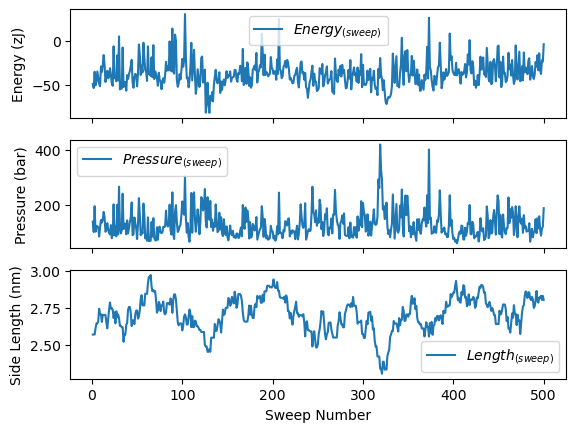

In [35]:
MCMC_2(298, 2.5, 50, 500, 0.5, 10, 10, 0.34, 1.65, 0.03806425, 300, 1)